# MNIST

In [80]:
from fastai.vision.all import *

Get MNIST sample data

In [81]:
URLs.MNIST_SAMPLE

'https://s3.amazonaws.com/fast-ai-sample/mnist_sample.tgz'

In [82]:
path = untar_data(URLs.MNIST_SAMPLE)
path

Path('.')

Change base path to path and list files

In [83]:
Path.BASE_PATH = path
path.ls()

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

In [84]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [85]:
(path/'train'/'7').ls()

(#6265) [Path('train/7/32208.png'),Path('train/7/79.png'),Path('train/7/54193.png'),Path('train/7/4545.png'),Path('train/7/2161.png'),Path('train/7/11473.png'),Path('train/7/3914.png'),Path('train/7/58565.png'),Path('train/7/8302.png'),Path('train/7/59871.png')...]

Create lists with locations of images for 3 and 7

In [86]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [87]:
im = Image.open(threes[1])
im

Some experimentation with data

In [88]:
array(im)[4:12,4:12]

array([[  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29, 150, 195],
       [  0,   0,   0,  48, 166, 224, 253, 253],
       [  0,  93, 244, 249, 253, 187,  46,  10],
       [  0, 107, 253, 253, 230,  48,   0,   0],
       [  0,   3,  20,  20,  15,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  14]], dtype=uint8)

In [89]:
tensor(im)[4:12,4:12]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29, 150, 195],
        [  0,   0,   0,  48, 166, 224, 253, 253],
        [  0,  93, 244, 249, 253, 187,  46,  10],
        [  0, 107, 253, 253, 230,  48,   0,   0],
        [  0,   3,  20,  20,  15,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,  14]], dtype=torch.uint8)

In [90]:
three_df = pd.DataFrame(tensor(im)[4:20,4:20])
three_df.style.set_properties().background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2


### Simple approach to identify pictures

In [91]:
threes_list = [tensor(Image.open(o)) for o in threes]
sevens_list = [tensor(Image.open(o)) for o in sevens]
len(threes_list), len(sevens_list)

(6131, 6265)

<AxesSubplot:>

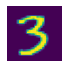

In [92]:
show_image(threes_list[1])

In [93]:
max([int(threes_list[i].max()) for i in range(len(threes_list))])

255

In [94]:
threes_stacked = torch.stack(threes_list).float()/255
sevens_stacked = torch.stack(sevens_list).float()/255
threes_stacked.shape, sevens_stacked.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

<AxesSubplot:>

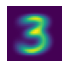

In [95]:
avg_three = threes_stacked.mean(0)
show_image(avg_three)

<AxesSubplot:>

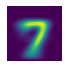

In [96]:
avg_seven = sevens_stacked.mean(0)
show_image(avg_seven)

Take one image and find diffences

In [97]:
(path/'valid'/'3').ls()

(#1010) [Path('valid/3/5309.png'),Path('valid/3/9812.png'),Path('valid/3/5635.png'),Path('valid/3/2072.png'),Path('valid/3/3094.png'),Path('valid/3/7075.png'),Path('valid/3/2069.png'),Path('valid/3/4638.png'),Path('valid/3/991.png'),Path('valid/3/323.png')...]

In [98]:
test_image = Image.open((path/'valid'/'3'/'5309.png'))
test_image

In [99]:
test_image_fin = (tensor(test_image).float()/255)

Find the error terms

In [100]:
l1_with_3 = (test_image_fin - avg_three).abs().mean()
l1_with_7 = (test_image_fin - avg_seven).abs().mean()
l1_with_3, l1_with_7

(tensor(0.1290), tensor(0.1769))

In [101]:
l2_with_3 = ((test_image_fin - avg_three)**2).abs().mean()
l2_with_7 = ((test_image_fin - avg_seven)**2).abs().mean()
l2_with_3, l2_with_7

(tensor(0.0561), tensor(0.1071))

### Score all the images using simple logic to find accuracy

In [102]:
valid_threes_paths = (path/'valid'/'3').ls()
valid_sevens_paths = (path/'valid'/'7').ls()
len(valid_threes_paths), len(valid_sevens_paths)

(1010, 1028)

In [103]:
valid_threes = torch.stack([tensor(Image.open(p)) for p in valid_threes_paths])
valid_sevens = torch.stack([tensor(Image.open(p)) for p in valid_sevens_paths])
valid_threes.shape, valid_sevens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

<AxesSubplot:>

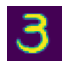

In [104]:
show_image(valid_threes[0])

In [105]:
valid3_losss_w3 = (valid_threes-avg_three).abs().mean((-1,-2))
valid3_losss_w7 = (valid_threes-avg_seven).abs().mean((-1,-2))
valid7_losss_w3 = (valid_sevens-avg_three).abs().mean((-1,-2))
valid7_losss_w7 = (valid_sevens-avg_seven).abs().mean((-1,-2))
valid3_losss_w3.shape, valid3_losss_w7.shape, valid3_losss_w7.shape, valid7_losss_w7.shape

(torch.Size([1010]),
 torch.Size([1010]),
 torch.Size([1010]),
 torch.Size([1028]))

In [106]:
accuracy_3 = sum(valid3_losss_w3 < valid3_losss_w7)/len(valid3_losss_w3)
accuracy_7 = sum(valid7_losss_w7 < valid7_losss_w3)/len(valid7_losss_w7)
accuracy_tot = (sum(valid3_losss_w3 < valid3_losss_w7)+sum(valid7_losss_w7 < valid7_losss_w3))/(len(valid3_losss_w3)+len(valid7_losss_w7))
accuracy_3, accuracy_7, accuracy_tot

(tensor(0.9436), tensor(0.9815), tensor(0.9627))

### Stocastic Gradient Descent

In [107]:
from fastbook import *

In [108]:
def f(x): return x**2

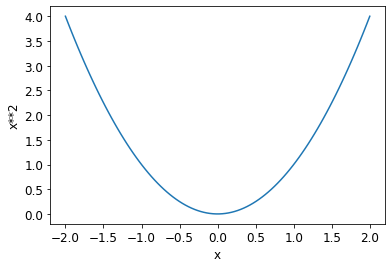

In [109]:
plot_function(f, 'x', 'x**2')

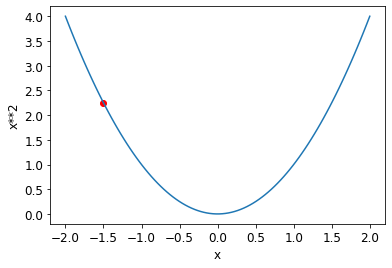

In [110]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red')

In [111]:
xt = tensor(3.).requires_grad_()
xt

tensor(3., requires_grad=True)

In [112]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [113]:
yt.backward()

In [114]:
xt.grad

tensor(6.)

In [115]:
xt = tensor([2.,3.,4.]).requires_grad_()
xt

tensor([2., 3., 4.], requires_grad=True)

In [116]:
yt = f(xt).sum()
yt

tensor(29., grad_fn=<SumBackward0>)

In [117]:
yt.backward()
xt.grad

tensor([4., 6., 8.])

### End-to-End SGD

In [324]:
time = torch.arange(20).float()
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

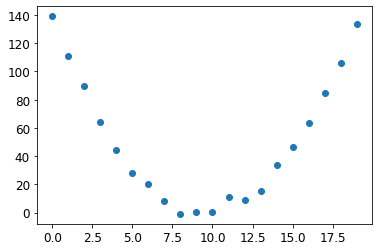

In [325]:
speed = 1.5*(time-9.5)**2 + 1 + torch.randn(20)*3
plt.scatter(time, speed)

In [326]:
def f(t, params):
    a,b,c = params
    return (a*t**2) + (b*t) + c

In [327]:
def mse(pred, actual): return ((pred-actual)**2).mean().sqrt()

**Step 1: Initialize Parameters**

In [328]:
params = torch.randn(3).requires_grad_()
params

tensor([-0.2823,  0.0510, -0.0177], requires_grad=True)

In [329]:
orig_params  = params.clone()
orig_params

tensor([-0.2823,  0.0510, -0.0177], grad_fn=<CloneBackward>)

**Step2: Calculate Predictions**

In [330]:
pred = f(time, params)
pred

tensor([-1.7705e-02, -2.4900e-01, -1.0449e+00, -2.4053e+00, -4.3303e+00, -6.8198e+00, -9.8739e+00, -1.3493e+01, -1.7676e+01, -2.2424e+01, -2.7736e+01, -3.3613e+01, -4.0054e+01, -4.7060e+01,
        -5.4631e+01, -6.2766e+01, -7.1466e+01, -8.0730e+01, -9.0559e+01, -1.0095e+02], grad_fn=<AddBackward0>)

In [331]:
def show_preds(pred, ax=None):
    if ax is None: ax = plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(pred), color='red')

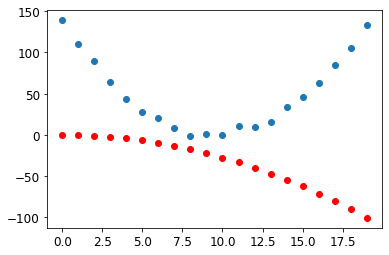

In [332]:
show_preds(pred)

**Step3: Calculate Loss**

In [333]:
loss = mse(pred, speed)
loss

tensor(104.3982, grad_fn=<SqrtBackward>)

**Step4: Calculate Gradients**

In [334]:
loss.backward()
params.grad

tensor([-146.5624,   -9.3544,   -0.8116])

**Step5: Step the weights**

In [335]:
lr = 1e-3
params.data -= lr*params.grad.data
params.grad = None

In [336]:
params

tensor([-0.1357,  0.0603, -0.0169], requires_grad=True)

In [337]:
pred = f(time, params)

In [338]:
mse(pred, speed)

tensor(83.6949, grad_fn=<SqrtBackward>)

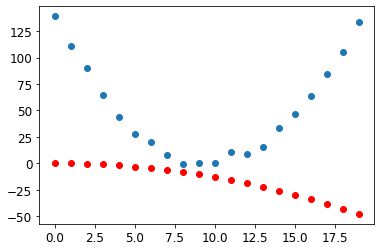

In [339]:
show_preds(pred)

**Step6: Loop through this proces multiple times**

In [340]:
def update_weights(params):
    pred = f(time, params)
    loss = mse(pred, speed)
    loss.backward()
    params.data -= lr*params.grad.data
    params.grad = None
    print(loss.item())
    return pred

In [341]:
for i in range(10): update_weights(params)

83.69485473632812
67.23494720458984
56.840248107910156
52.3720817565918
51.11370086669922
50.838470458984375
50.78293228149414
50.7718505859375
50.769561767578125
50.769004821777344


50.76879119873047


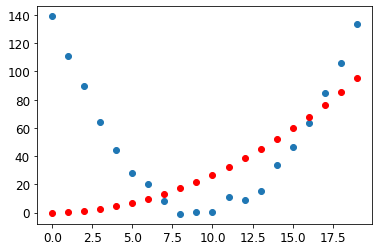

In [342]:
pred = update_weights(params)
show_preds(pred)

104.39822387695312
83.69485473632812
67.23494720458984
56.840248107910156
52.3720817565918
51.11370086669922
50.838470458984375
50.78293228149414
50.7718505859375
50.769561767578125


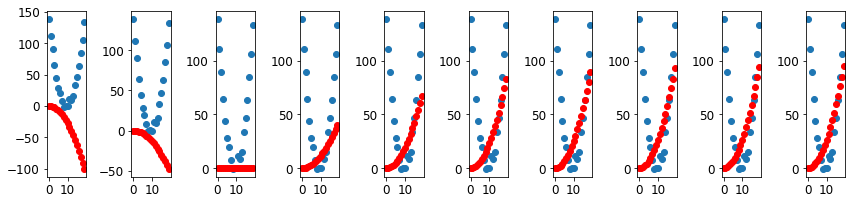

In [343]:
params = orig_params.detach().requires_grad_()
_,axs = plt.subplots(1,10,figsize=(12,3))
for ax in axs: show_preds(update_weights(params), ax)
plt.tight_layout()